In [34]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from tqdm.auto import tqdm
tqdm.pandas()


import sys, os
sys.path.append(os.path.abspath('../'))
from scripts.utils import create_dir, get_runtime
import time
start_time = time.time()


In [2]:
# load 2029 data
data_future_unit = pd.read_csv("../data/curated/suburb-unit-25-27.csv")
data_future_house = pd.read_csv("../data/curated/suburb-house-25-27.csv")

In [3]:
data_future_house.shape

(4341, 12)

In [4]:
# Load rental dataset from curated layer
rental_df = pd.read_csv('../data/curated/rental-17-24.csv')
rental_df['sa2_code'] = rental_df['sa2_code'].astype('Int64').astype(str)
rental_df = rental_df[[
    'suburb', 'sa2_code', 'type', 'year', 'bed', 'bath', 'car', 'median_income',
    'population', 'cpi', 'unemployment_rate', 'time_city', 'avg_property_price',
    'rented_price'
]]
rental_df

,suburb,sa2_code,type,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price
0,Melbourne,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
1,Melbourne,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
2,Melbourne,206041505,Unit/apmt,2021,2.0,2.0,1.0,39300.000000,16098.0,3.50,4.200000,263.3,619543.745192,540
3,Melbourne,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,720
4,Melbourne,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409722,Pakenham,212011552,House,2024,3.0,1.0,0.0,55683.420715,28466.0,3.53,4.014286,3251.4,843219.858156,520
1409723,Pakenham,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409724,Pakenham,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409725,Pakenham,212011550,Unit/apmt,2024,4.0,2.0,2.0,58924.808098,9820.0,3.53,4.014286,3297.1,843219.858156,580


<Axes: xlabel='year', ylabel='rented_price'>

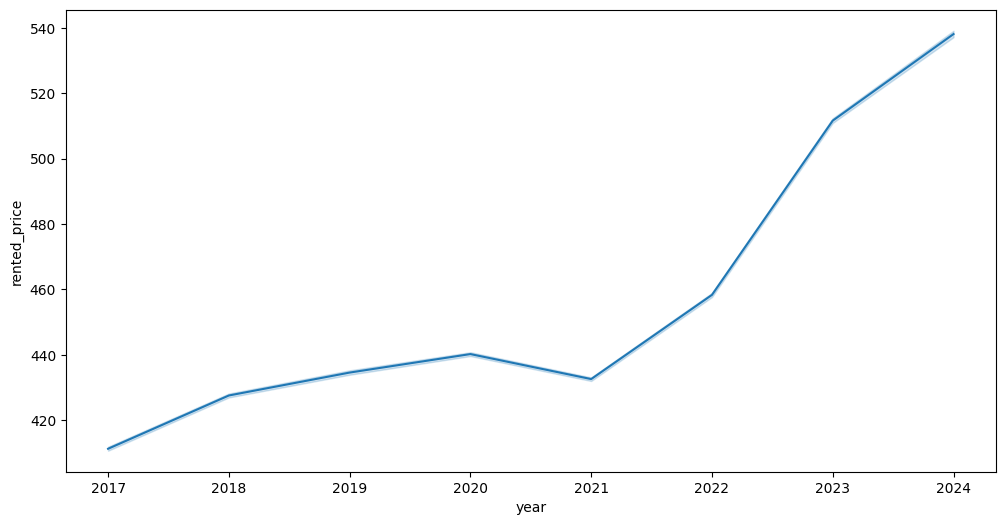

In [5]:
# plt the graph between rented price vs year
plt.figure(figsize=(12, 6))
sns.lineplot(data=rental_df, x='year', y='rented_price')

As the graphs shows a big difference between precovid and post covid, we will only be considering data from year 2021

In [6]:
rental_df.drop_duplicates(inplace=True)

In [7]:
rental_df = rental_df[rental_df["year"] >=2021]

year 2021 and 2022 will be used for training and year 2023 and 2024 will be used for testing

In [8]:
hist_df = rental_df[
    (rental_df['year'] >= 2021) &
    (rental_df['year'] <= 2023)
]
curr_df = rental_df[
    (rental_df['year'] > 2023) &
    (rental_df['year'] <= 2024)
]

In [9]:
# parition curr and hist dataframes based on type: 'House' and 'Unit/apmt'
hist_house_df = hist_df[hist_df['type'] == 'House']
hist_unit_df = hist_df[hist_df['type'] == 'Unit/apmt']
curr_house_df = curr_df[curr_df['type'] == 'House']
curr_unit_df = curr_df[curr_df['type'] == 'Unit/apmt']

# drop 'type' column
hist_house_df.drop(columns=['type'], inplace=True)
hist_unit_df.drop(columns=['type'], inplace=True)
curr_house_df.drop(columns=['type'], inplace=True)
curr_unit_df.drop(columns=['type'], inplace=True)

# print the shape of each dataframe
print('hist_house_df:', hist_house_df.shape)
print('hist_unit_df:', hist_unit_df.shape)
print('curr_house_df:', curr_house_df.shape)
print('curr_unit_df:', curr_unit_df.shape)

hist_house_df: (152134, 13)
hist_unit_df: (260609, 13)
curr_house_df: (26782, 13)
curr_unit_df: (51166, 13)


/tmp/ipykernel_6410/4217374014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_house_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_6410/4217374014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_6410/4217374014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_house_df.drop(columns=['type'], inplace=True)
/tmp/ipykernel_6410/4217374014.py:11:

In [10]:
# remove irregular data

hist_house_df = hist_house_df[hist_house_df["bath"] < 5]
curr_house_df = curr_house_df[curr_house_df["bath"] < 5]

In [11]:
MIN_INSTANCES_PER_SUBURB = 100

In [12]:
# find the number of suburbs with more than 1000 instances
hist_house_df['count'] = hist_house_df.groupby('suburb')['suburb'].transform('count')
hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]['suburb'].nunique()

hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')

curr_house_df['count'] = curr_house_df.groupby('suburb')['suburb'].transform('count')
curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


/tmp/ipykernel_6410/2247219211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')
/tmp/ipykernel_6410/2247219211.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


In [13]:


# add a new column which is the count of the entries within that suburb

high_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] >= MIN_INSTANCES_PER_SUBURB]
high_confidence_house_hist = hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]

low_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] < MIN_INSTANCES_PER_SUBURB]
low_confidence_house_hist = hist_house_df[hist_house_df['count'] < MIN_INSTANCES_PER_SUBURB]

high_unit_confidence_suburb = high_confidence_unit_hist['suburb'].unique()
low_unit_confidence_suburb = low_confidence_unit_hist['suburb'].unique()

high_house_confidence_suburb = high_confidence_house_hist['suburb'].unique()
low_house_confidence_suburb = low_confidence_house_hist['suburb'].unique()

In [14]:
high_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(high_house_confidence_suburb)]
low_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(low_house_confidence_suburb)]

high_confidence_house_curr = high_confidence_house_curr[high_confidence_house_curr['rented_price']>300]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>300]

high_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(high_unit_confidence_suburb)]
low_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(low_unit_confidence_suburb)]

high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price']>200]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>200]

In [15]:
numeric_features = ['bed, bath, car, year, median_income, population, cpi, unemployment_rate, time_city', 'avg_property_price',"count"]

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Defining the ColumnTransformer for one-hot encoding 'type' and standardizing numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

def run_0R(X_train, X_test, y_train):
    zero_r_model = DummyRegressor(strategy='mean')
    zero_r_model.fit(X_train, y_train)
    # print training score
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {zero_r_model.score(X_train, y_train)}")
    return zero_r_model.predict(X_test)

def run_LR(X_train, X_test, y_train):
    # Initialize and fit the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Get the predicted values
    predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients
    coef = lr_model.coef_
    
    # Create a DataFrame to pair feature names with their corresponding coefficients
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    
    # Sort the DataFrame by the absolute value of the coefficients (most relevant feature first)
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Display the most relevant features (sorted by the coefficient's absolute value)
    
    
    return predictions,feature_importance

def run_RF(X_train, X_test, y_train):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)

    return rf_model.predict(X_test)

def run_MLP(X_train, X_test, y_train):
    mlp_model = MLPRegressor(random_state=1, max_iter=300)
    mlp_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {mlp_model.score(X_train, y_train)}")
    return mlp_model.predict(X_test)

def run_KNN(X_train, X_test, y_train):
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {knn_model.score(X_train, y_train)}")
    return knn_model.predict(X_test)

def run_SVR(X_train, X_test, y_train):
    from sklearn.svm import SVR
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {svr_model.score(X_train, y_train)}")
    return svr_model.predict(X_test)

def run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5):
    # Ensure weights sum to 1
    assert weight_lr + weight_rf == 1, "The sum of the weights should be 1."
    
    # --- Linear Regression ---
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients for LR
    coef = lr_model.coef_
    feature_importance_lr = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
    feature_importance_lr = feature_importance_lr.sort_values(by='Abs_Coefficient', ascending=False)

    # --- Random Forest ---
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    # Combine predictions by averaging (weighted average can be applied)
    combined_predictions = (weight_lr * lr_predictions) + (weight_rf * rf_predictions)

    # You can choose to return the feature importances for both models or just LR
    return combined_predictions, feature_importance_lr



def display_metrics(y_test, y_pred_zero_r,y_pred_lr,y_pred_rf):
    # Compute evaluation metrics for ZeroR
    mse_zero_r = mean_squared_error(y_test, y_pred_zero_r)
    r2_zero_r = r2_score(y_test, y_pred_zero_r)
    # Compute evaluation metrics for Linear Regression
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    # Compute evaluation metrics for Random Forest
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    # get variance of the target variable
    variance = y_test.var()      
    # Output the results
    print("ZeroR (Baseline) Model")
    print(f"Mean Squared Error (MSE): {mse_zero_r}")
    print(f"R-Squared (R2 Score): {r2_zero_r}\n")
    print("Linear Regression Model")
    print(f"Mean Squared Error (MSE): {mse_lr}")
    print(f"R-Squared (R2 Score): {r2_lr}\n")
    print("Random Forest Model")
    print(f"Mean Squared Error (MSE): {mse_rf}")
    print(f"R-Squared (R2 Score): {r2_rf}")
    print(f"Variance of the target variable: {variance}")

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def model_and_predict(df1, future_df):
    Prior_2021 = df1
    # set intersection of suburbs in the future data and the training data
    suburb_testing = set(future_df['suburb'].unique().tolist()).intersection(set(Prior_2021['suburb'].unique().tolist()))
    list_future_df = []
    missing_suburbs = []
    print("Suburbs to predict: ", len(suburb_testing))
    for i in tqdm(suburb_testing):
        # Filter the data by suburb
        Prior_2021_suburb = Prior_2021[Prior_2021['suburb'] == i]
        if Prior_2021_suburb.shape[0] == 0:
            missing_suburbs.append(i)
            continue
        X_train = Prior_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        y_train = Prior_2021_suburb['rented_price']
        
        col_names = X_train.columns
        
        xy_future = future_df[future_df['suburb'] == i].copy()
        x_future = xy_future.drop(columns=[ 'suburb','rented_price'])
        x_future = x_future.reindex(col_names, axis=1)

        # future prediction
        if not x_future.empty:
            xy_future.loc[:,'pred_0r'] = run_0R(X_train, x_future, y_train)
            xy_future.loc[:,'pred_lr'],_ = run_LR(X_train, x_future, y_train)
            xy_future.loc[:,'pred_rf'] = run_RF(X_train, x_future, y_train)
            xy_future.loc[:,'pred_combine'],_ = run_combine_models(X_train, x_future, y_train, weight_lr=0.5, weight_rf=0.5)
        else:
            tqdm.write(f"Suburb {i} has no future data")
            xy_future.loc[:,'pred_0r'] = np.nan
            xy_future.loc[:,'pred_lr'] = np.nan
            xy_future.loc[:,'pred_rf'] = np.nan
            xy_future.loc[:,'pred_combine'] = np.nan
            
        list_future_df.append(xy_future)
    return pd.concat(list_future_df), missing_suburbs
    
    
def modeling(df1, df2):
    Prior_2021 = df1
    After_2021 = df2

    suburb_testing = After_2021['suburb'].unique()
    
    # Initialize lists to collect results
    average_mse_zero_r = []
    average_mse_lr = []
    average_mse_rf = []
    average_r2_combine = []
    
    bad_prediction = []
    good_prediction = []
    
    # Initialize dictionary to aggregate feature importances across all suburbs
    feature_importance_sum = pd.DataFrame()
    # Loop over all suburbs
    for i in tqdm(suburb_testing):
        # Filter the data by suburb
        Prior_2021_suburb = Prior_2021[Prior_2021['suburb'] == i]
        After_2021_suburb = After_2021[After_2021['suburb'] == i]

        X_train = Prior_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        X_test = After_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code','count'])
        y_train = Prior_2021_suburb['rented_price']
        y_test = After_2021_suburb['rented_price']
        
    
        
        # Run the models
        y_pred_zero_r = run_0R(X_train, X_test, y_train)
        y_pred_lr, feature_importance = run_LR(X_train, X_test, y_train)
        y_pred_rf = run_RF(X_train, X_test, y_train)
        y_pred_combine, _ = run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5)
        # future prediction
        
        # Calculate R2 scores
        r2_lr = r2_score(y_test, y_pred_lr)
        r2_rf = r2_score(y_test, y_pred_rf)
        r2_combine = r2_score(y_test, y_pred_combine)

        # Store the R2 results for analysis
        average_mse_zero_r.append(r2_score(y_test, y_pred_zero_r))
        average_mse_lr.append(r2_lr)
        average_mse_rf.append(r2_rf)
        average_r2_combine.append(r2_combine)
        
        # Sum up feature importances across suburbs for LR
        if feature_importance_sum.empty:
            feature_importance_sum = feature_importance.set_index('Feature')
        else:
            feature_importance_sum['Coefficient'] += feature_importance.set_index('Feature')['Coefficient']

    res_df = pd.DataFrame({'suburb':After_2021['suburb'].unique()})
    res_df['r2_0r'] = average_mse_lr
    res_df['r2_lr'] = average_mse_lr
    res_df['r2_rf'] = average_mse_rf
    res_df['r2_combine'] = average_r2_combine
    # Remove negative R2 values
    average_mse_lr = [x for x in average_mse_lr if x >= 0]
    average_mse_rf = [x for x in average_mse_rf if x >= 0] 
    average_r2_combine = [x for x in average_r2_combine if x >= 0]
    
    # Print average R2 scores for LR, RF, and Combined
    print('Average R2 Score LR:', np.mean(average_mse_lr))
    print('Average R2 Score RF:', np.mean(average_mse_rf))
    print('Average R2 Score Combined:', np.mean(average_r2_combine))
    
    # Print bad and good predictions if applicable
    # print(bad_prediction)
    # print(good_prediction)

    # Find the top 5 most important features overall (based on summed coefficients from LR)
    feature_importance_sum['Abs_Coefficient'] = feature_importance_sum['Coefficient'].abs()
    top_5_features = feature_importance_sum.sort_values(by='Abs_Coefficient', ascending=False).head(5)

    # Print the top 5 most important features
    print("Top 5 most important features across all suburbs:")
    print(top_5_features[['Coefficient', 'Abs_Coefficient']])
    return res_df


# Modelling high confidnece house

In [29]:
r2_list = []

In [17]:


# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Loop over the years and plot each year's distribution in a separate subplot
# for idx, i in enumerate(range(2017, 2025)):
#     wyndham_vale = rental_df[(rental_df['suburb'] == 'BALLARAT CENTRAL') & (rental_df['year'] == i)]
#     sns.histplot(wyndham_vale["rented_price"], kde=True, bins=30, ax=axes[idx])
#     axes[idx].set_title(f'MELBOURNE Rented Price Distribution in {i}')
#     axes[idx].set_xlabel('Rented Price')
#     axes[idx].set_ylabel('Frequency')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

/tmp/ipykernel_1421/1875330463.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Year')


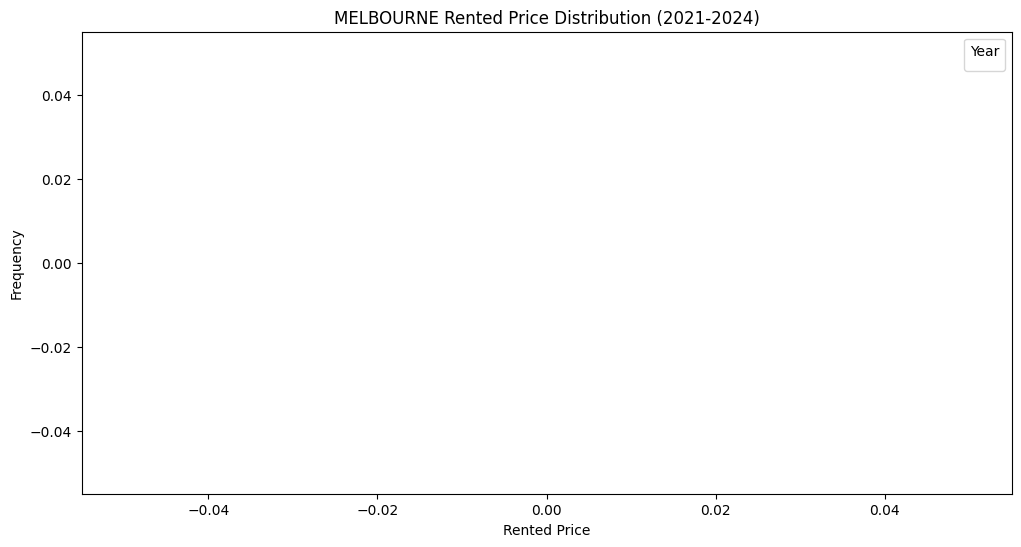

In [18]:
# Create a figure for the combined plot
plt.figure(figsize=(12, 6))

# Loop over the years and plot each year's distribution on the same figure
for i in range(2017, 2025):
    wyndham_vale = rental_df[(rental_df['suburb'] == 'SOUTH YARRA') & (rental_df['year'] == i)]
    sns.histplot(wyndham_vale["rented_price"], kde=True, label=f'{i}', bins=30)

# Add title and labels
plt.title('MELBOURNE Rented Price Distribution (2021-2024)')
plt.xlabel('Rented Price')
plt.ylabel('Frequency')

# Show the legend
plt.legend(title='Year')

# Display the plot
plt.show()

## house

In [16]:
df1 = high_confidence_house_hist
df2 = high_confidence_house_curr

In [26]:
r2_score_df = modeling(df1,df2)
r2_score_df['type'] = 'House'
r2_score_df['confidence'] = 'high'
r2_list.append(r2_score_df)

100%|██████████| 283/283 [00:40<00:00,  6.93it/s]

Average R2 Score LR: 0.28014076487173745
Average R2 Score RF: 0.2741285544417377
Average R2 Score Combined: 0.2885845615146569
Top 5 most important features across all suburbs:
                    Coefficient  Abs_Coefficient
Feature                                         
bed                13705.450946     13705.450946
bath               12441.911762     12441.911762
year               -6079.947007      6079.947007
car                 2280.367610      2280.367610
unemployment_rate    934.458552       934.458552


# Modelling high confidence unit/apmt

In [32]:
# bathroom should be less than 2

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] <= 2]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] <= 2]

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] > 0]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] > 0]

# car park should be less than 3

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['car'] <= 3]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['car'] <= 3]

# eliminate apartment with more than 1400 per week

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['rented_price'] <= 1400]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price'] <= 1400]

In [35]:
df1 = high_confidence_unit_hist
df2 = high_confidence_unit_curr

r2_score_df = modeling(df1,df2)
r2_score_df['type'] = 'Unit'
r2_score_df['confidence'] = 'high'
r2_list.append(r2_score_df)

  0%|          | 0/293 [00:00<?, ?it/s]

100%|██████████| 293/293 [00:52<00:00,  5.63it/s]

Average R2 Score LR: 0.4339218072524045
Average R2 Score RF: 0.3821427062818532
Average R2 Score Combined: 0.434556315462742
Top 5 most important features across all suburbs:
          Coefficient  Abs_Coefficient
Feature                               
year    -28505.663755     28505.663755
bed      20412.585289     20412.585289
bath     17965.905498     17965.905498
cpi       6932.762426      6932.762426
car       4569.266460      4569.266460


In [25]:
# # taking Melbourne city as an example to observe the model performance

# Melbourne_train = high_confidence_unit_hist[high_confidence_unit_hist['suburb'] == 'MELBOURNE']
# Melbourne_test = high_confidence_unit_curr[high_confidence_unit_curr['suburb'] == 'MELBOURNE']

# X_train = Melbourne_train.drop(columns=['rented_price','suburb','sa2_code'])
# X_test = Melbourne_test.drop(columns=['rented_price','suburb','sa2_code'])
# y_train = Melbourne_train['rented_price']
# y_test = Melbourne_test['rented_price']


# def run_RF(X_train, X_test, y_train):
#     rf_model = RandomForestRegressor(n_estimators=150, random_state=1, max_depth=5)
#     rf_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     # print important features
#     importances = rf_model.feature_importances_
#     feature_names = X_train.columns  # If X_train is a pandas DataFrame
#     feature_importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importances
#     })
#     feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#     # print(feature_importance_df.head())  # Display the top features

#     return rf_model.predict(X_test)

# def run_logistic(X_train, X_test, y_train):
#     from sklearn.linear_model import LogisticRegression
#     logistic_model = LogisticRegression(random_state=1)
#     logistic_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     #print(f"Training Score: {logistic_model.score(X_train, y_train)}")
#     return logistic_model.predict(X_test)

# def run_ridge(X_train, X_test, y_train):
#     from sklearn.linear_model import Ridge
#     ridge_model = Ridge(alpha=1.0)
#     ridge_model.fit(X_train, y_train)
#     #print("ZeroR (Baseline) Model")
#     #print(f"Training Score: {ridge_model.score(X_train, y_train)}")
#     return ridge_model.predict(X_test)

# y_pred_rf = run_RF(X_train, X_test, y_train)
# y_pred_ridge = run_ridge(X_train, X_test, y_train)


# r2_rf = r2_score(y_test, y_pred_rf)
# r2_ridge = r2_score(y_test, y_pred_ridge)


# print(r2_rf,r2_ridge)
# Melbourne_test

# Modelling low confidence house

In [36]:
df1 = low_confidence_unit_hist
df2 = low_confidence_unit_curr
r2_score_df = modeling(df1,df2)
r2_score_df['type'] = 'House'
r2_score_df['confidence'] = 'low'
r2_list.append(r2_score_df)

  1%|          | 4/421 [00:00<00:37, 11.07it/s]/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 scor

Average R2 Score LR: 0.4172323281852808
Average R2 Score RF: 0.37645448472464255
Average R2 Score Combined: 0.44108360894262544
Top 5 most important features across all suburbs:
                     Coefficient  Abs_Coefficient
Feature                                          
median_income      -2.572311e+10     2.572311e+10
population         -2.076861e+10     2.076861e+10
avg_property_price  8.811852e+09     8.811852e+09
year                3.467612e+09     3.467612e+09
cpi                 1.047637e+07     1.047637e+07


# Modelling low confidence unit/apmt

In [39]:
df1 = low_confidence_unit_hist
df2 = low_confidence_unit_curr
r2_score_df = modeling(df1,df2)
r2_score_df['type'] = 'Unit'
r2_score_df['confidence'] = 'low'
r2_list.append(r2_score_df)

  1%|          | 4/421 [00:00<00:39, 10.56it/s]/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/even/repo/project-2-group-real-estate-industry-project-2/.venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 scor

Average R2 Score LR: 0.4172323281852808
Average R2 Score RF: 0.37645448472464255
Average R2 Score Combined: 0.44108360894262544
Top 5 most important features across all suburbs:
                     Coefficient  Abs_Coefficient
Feature                                          
median_income      -2.572311e+10     2.572311e+10
population         -2.076861e+10     2.076861e+10
avg_property_price  8.811852e+09     8.811852e+09
year                3.467612e+09     3.467612e+09
cpi                 1.047637e+07     1.047637e+07


<Axes: >

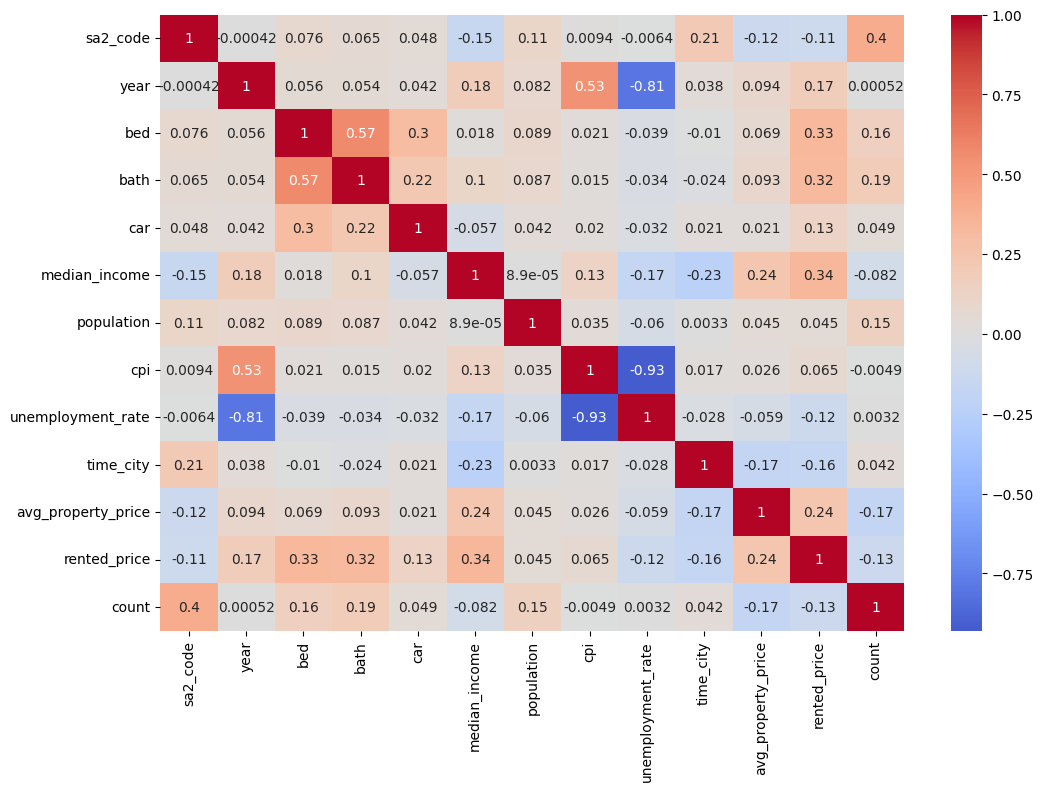

In [29]:
# plot a correlation map between all variables
plt.figure(figsize=(12, 8))
sns.heatmap(high_confidence_house_hist.drop(columns=["suburb"]).corr(), annot=True, cmap='coolwarm', center=0)

# R2 score out

In [41]:
pd.concat(r2_list).to_csv("../data/curated/r2_score.csv", index=False)

# predict dataset

In [42]:
predict_house_high, missing_house_high = model_and_predict(high_confidence_house_hist,data_future_house)
predict_house_high['confidence'] = 'high'

predict_unit_high, missing_unit_high = model_and_predict(high_confidence_unit_hist, data_future_unit)
predict_unit_high['confidence'] = 'high'

predict_house_low, missing_house_low = model_and_predict(low_confidence_house_hist,data_future_house)
predict_house_low['confidence'] = 'low'

predict_unit_low, missing_unit_low = model_and_predict(low_confidence_unit_hist,data_future_unit)
predict_unit_low['confidence'] = 'low'

Suburbs to predict:  283


100%|██████████| 283/283 [00:41<00:00,  6.85it/s]


Suburbs to predict:  293


100%|██████████| 293/293 [00:47<00:00,  6.15it/s]


Suburbs to predict:  830


100%|██████████| 830/830 [01:12<00:00, 11.46it/s]


Suburbs to predict:  710


100%|██████████| 710/710 [01:02<00:00, 11.39it/s]


In [43]:
house_sub = predict_house_high['suburb'].unique().tolist()
predict_house_low = predict_house_low[~predict_house_low['suburb'].isin(house_sub)]
predict_house = pd.concat([predict_house_high, predict_house_low])
predict_house.sort_index(inplace=True)
predict_house.to_csv("../data/curated/predict_house.csv", index=False)

In [44]:
unit_sub  = predict_unit_high['suburb'].unique().tolist()
predict_unit_low = predict_unit_low[~predict_unit_low['suburb'].isin(unit_sub)]
predict_unit = pd.concat([predict_unit_high, predict_unit_low])
predict_unit.sort_index(inplace=True)
predict_unit.to_csv("../data/curated/predict_unit.csv", index=False)

In [36]:
predict_house['suburb'].nunique(), predict_unit['suburb'].nunique()

(898, 934)

In [47]:
predict_unit_high.sort_values(by='pred_lr', ascending=True).head(20)

,suburb,year,bed,bath,car,time_city,avg_property_price,rented_price,cpi,unemployment_rate,median_income,population,pred_0r,pred_lr,pred_rf,pred_combine,confidence
2231,Mornington (Vic.),2027,2.676034,1.437045,1.525281,3678.309724,870664.752346,481.187717,2.68,4.62,65110.860275,13184.5,536.222482,-164050.672532,522.281469,-81764.195531,high
2230,Mornington (Vic.),2026,2.676034,1.437045,1.525281,3678.309724,870664.752346,481.187717,2.68,4.59,62629.447201,13155.5,536.222482,-131770.171998,522.281469,-65623.945265,high
2229,Mornington (Vic.),2025,2.676034,1.437045,1.525281,3678.309724,870664.752346,481.187717,2.98,4.50,60191.171825,13116.5,536.222482,-97483.760091,522.281469,-48480.739311,high
2822,Rye,2027,2.653988,1.309202,1.580368,6942.116564,934571.436474,446.252761,2.68,4.62,53185.945789,20908.0,521.828947,-7746.239133,509.964479,-3618.137327,high
2821,Rye,2026,2.653988,1.309202,1.580368,6942.116564,934571.436474,446.252761,2.68,4.59,51788.851448,20752.0,521.828947,-6317.343623,509.964479,-2903.689572,high
2820,Rye,2025,2.653988,1.309202,1.580368,6942.116564,934571.436474,446.252761,2.98,4.50,50506.179393,20583.0,521.828947,-4814.523438,509.964479,-2152.279480,high
1085,East Geelong,2027,2.737569,1.129834,1.133287,270.275483,738339.802604,365.856354,2.68,4.62,61937.821256,14876.5,434.446721,-1187.874242,434.533627,-376.670307,high
1083,East Geelong,2025,2.737569,1.129834,1.133287,270.275483,738339.802604,365.856354,2.98,4.50,58485.543785,14624.5,434.446721,-1177.818524,434.533627,-371.642448,high
854,Cremorne (Vic.),2027,1.783721,1.316279,0.897674,497.500698,741844.978064,568.669767,2.68,4.62,93805.162062,19325.0,569.340102,-1169.280855,637.031047,-266.124904,high
1084,East Geelong,2026,2.737569,1.129834,1.133287,270.275483,738339.802604,365.856354,2.68,4.59,60198.028711,14741.0,434.446721,-1168.241142,434.533627,-366.853757,high


count how many suburbs processed

In [93]:
suburb_l = sorted(hist_unit_df['suburb'].unique().tolist())

In [97]:
missing_suburb = []
for subrub in data_future_house['suburb'].unique():
    if subrub not in predict_house['suburb'].unique():
        missing_suburb.append(subrub)

In [ ]:
len(missing_suburb)

In [99]:
in_both = []
not_both = []
for subrub in missing_suburb:
    if subrub in suburb_l:
        in_both.append(subrub)
    else:
        not_both.append(subrub)


In [ ]:
temp = hist_house_df[hist_house_df['suburb'].isin(in_both)]
temp.groupby('suburb')['suburb'].count().sort_index()
